In [141]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torch import optim
import pickle
from matplotlib import pyplot as plt
from libs_unet.models import unet_004
from libs_unet.training.libs_train import train_loop, test_loop
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import datetime
from libs_unet.training.spec_maker import spectrum_maker
top_dir = Path.cwd()
datapath = top_dir / 'data'
#load reference data
elem_symb = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)

In [152]:
#Leverage PyTorch native Dataset and DataLoader 
#Define Train/Test sets from 20 element data samples
with open(datapath / 'training/10k_nomods.pickle', 'rb') as f:
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)

#create dataset of single spectrum to see if model can learn it
#input needs a placeholder "channel" dimension since single channel
#learned labels already has max_z + 2 channels from spec_array
#data has to match weights which default to float() so cast data as same
scale_factor = 10**4

x_data = torch.tensor(x_data[0, None, :].astype('float32'))
x_data = x_data[None,:,:]
y_data = torch.tensor(y_data[0,:,:].astype('float32'))
y_data = y_data[None,:,:]
#push any negative values to zero
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
x_data = 5 * torch.log( scale_factor * x_data + 1)
y_data = 5 * torch.log( scale_factor * y_data + 1)

#scale such that 

spec_ds = TensorDataset(x_data, y_data)
#batch sizes
train_bs = 1
train_dl = DataLoader(spec_ds, batch_size=train_bs)
#

<function matplotlib.pyplot.show(close=None, block=None)>

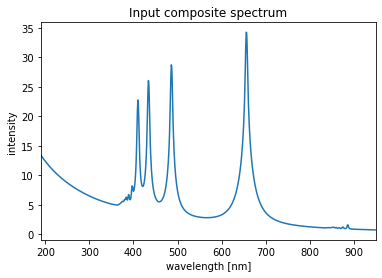

In [153]:
plt.plot(torch.arange(190,950), y_data[0,0,:])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.title('Input composite spectrum')
plt.show

In [154]:
#check max/min
print(f"input min:{torch.min(x_data)} input max: {torch.max(x_data)}")
print(f"output min:{torch.min(y_data)} output max: {torch.max(y_data)}")

input min:1.707108497619629 input max: 34.27165985107422
output min:0.0 output max: 34.270606994628906


In [155]:
#Alternative data: manufacture specific composite(s) to overtrain
#Initial case is to attempt a 50/50 split to see if model picks one or fits both
#choose 50/50 Li/O, ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O']
# fracs = np.array([0, 0, 0.5, 0, 0, 0, 0, 0.5])
# my_maker = spectrum_maker(8)
# wave, spec, spec_array = my_maker.make_spectra(fracs)
# x_data = torch.tensor(spec[None,None,:].astype('float32'))
# y_data = torch.tensor(spec_array[None,:,:].astype('float32'))
# spec_ds = TensorDataset(x_data, y_data)
# train_bs = 1
# train_dl = DataLoader(spec_ds, batch_size=train_bs)

In [156]:
#set parameters
el_count = 20 #first n elements used to construct model
wl_points = 760 #number of wavelength point measurements in data
learning_rate = 1 #There is a schedule to reduce as loss plateaus
lr_patience = 1000
lr_cooldown = 10
lr_thresh = 0.01
epochs = 1000
debug = True

#Initialize and run
model = unet_004.LIBSUNet(el_count, wl_points)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#lr_scheduler = MultiStepLR(optimizer, milestones=[5000], gamma=0.1)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=lr_patience,
                                 cooldown=lr_cooldown, threshold=lr_thresh)
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') #  now 
writerpath = Path('./runs/'+now_time)
writer = SummaryWriter(writerpath)
#add model to tensorboard
#writer.add_graph(model,train_ds)
prior_lr = learning_rate
print(f"starting training with learning rate {prior_lr}")
for t in range(epochs):
    if optimizer.param_groups[0]['lr'] != prior_lr:
        print(f"Epoch {t+1}, learning rate {optimizer.param_groups[0]['lr']}\n-------------------------------")
        prior_lr = optimizer.param_groups[0]['lr']
    tr_loss = train_loop(train_dl, model, loss_fn, optimizer, writer, t+1, log_interval=1, debug=debug)
    lr_scheduler.step(tr_loss)
print("Done!") #loss asymptotes to 1.81e-6 

#cleanup
writer.flush()
writer.close()


starting training with learning rate 1
Done!


sum x: 1638941327360.0
H: 1636982718464.000000
B: 1.702608
F: 198881.343750
Ar: 0.055491


/var/folders/yj/sjr_202x2fvfp9wq2lrrdf0h0000gn/T/ipykernel_12623/1974697539.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


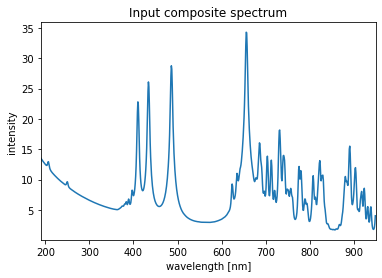

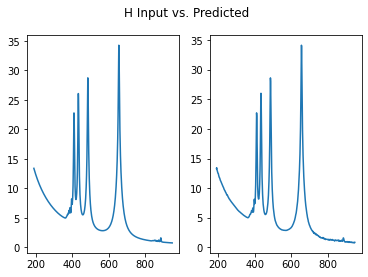

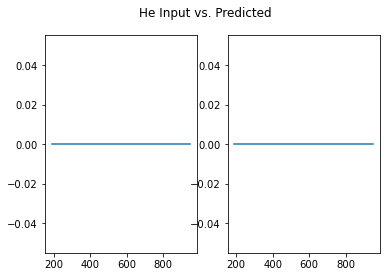

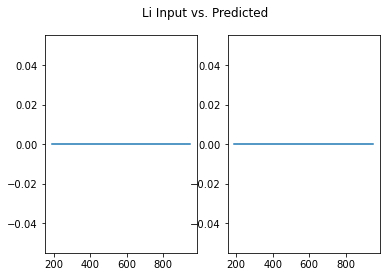

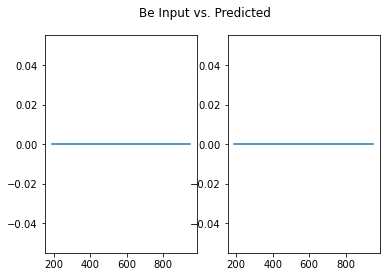

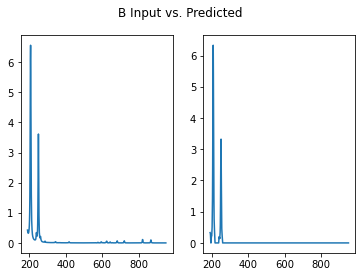

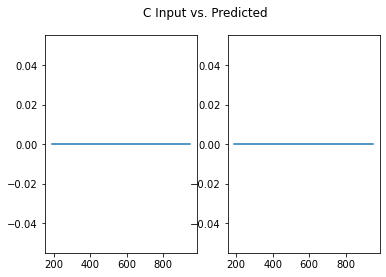

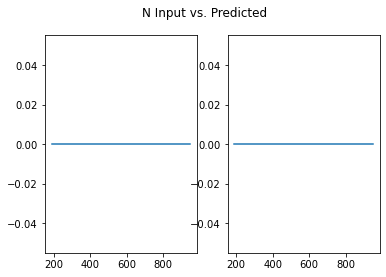

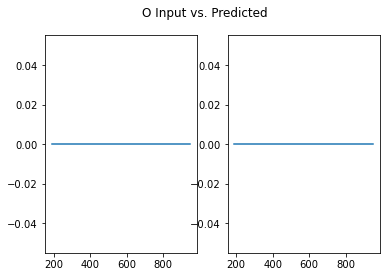

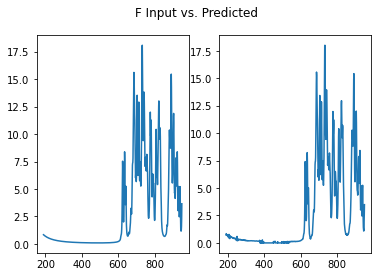

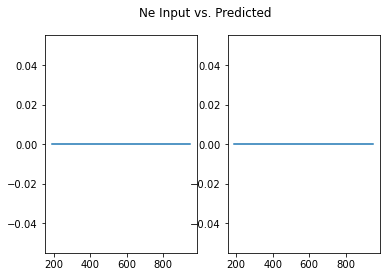

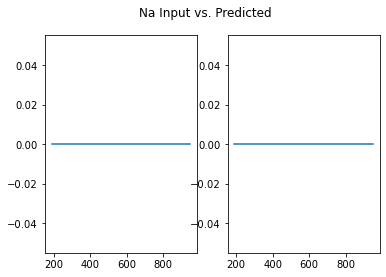

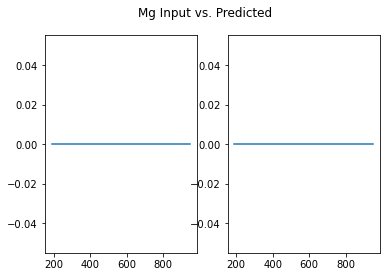

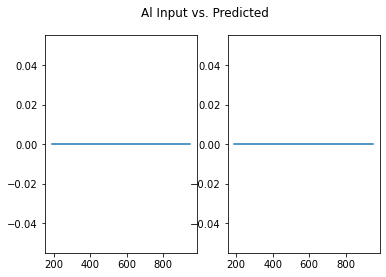

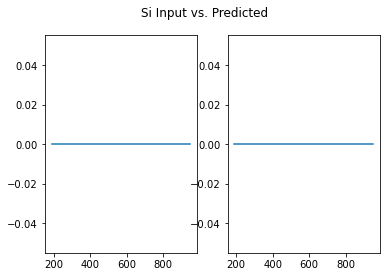

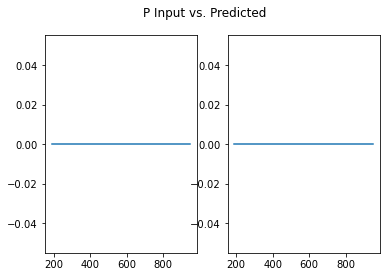

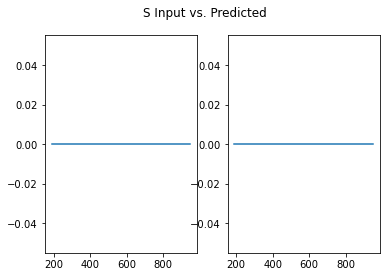

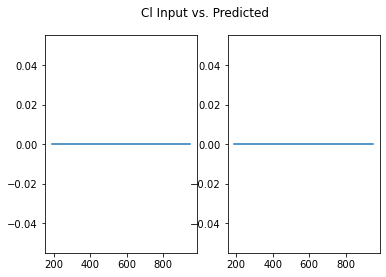

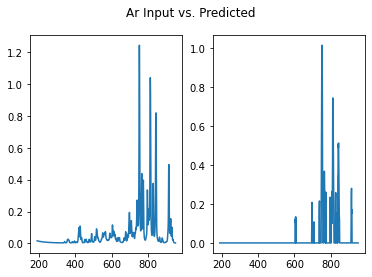

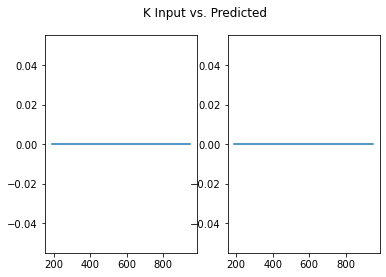

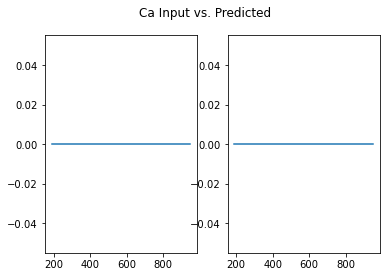

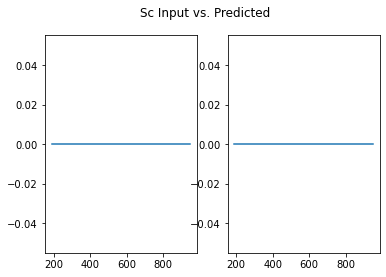

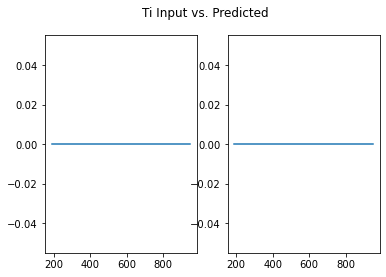

In [157]:
#look at the predicted vs. reference spectra. Leave transformed for plotting
i_samp = 0 #vary up to 9999
x_sample = x_data[i_samp][None, :, :] #need correct dimensions with batch for prediction
y_sample = y_data[i_samp].detach().numpy() #[22][760] # 20+2 (el + art + noi) spectra

#composite spectra and components
print(f"sum x: {torch.sum((torch.exp(x_sample[0][0])-1)/1000)}")
#show the element fractions
for i in range(el_count):
    frac = np.sum((np.exp(y_sample[i]) - 1)/1000)
    if frac > 0:
        print(f"{elem_symb[i]}: {frac:>4f}")
        
wave = np.arange(190,950)
#first plot the composite input spectrum we're trying to decompose
plt.plot(wave, x_sample[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.title('Input composite spectrum')
plt.show

plot_thresh = 0.1
#prediction
model.eval()
with torch.no_grad():
    pred = model(x_sample)
    y_pred = pred[0].detach().numpy() #[22][760] corresponding predictions for y_sample
    y_pred[y_pred < plot_thresh] = 0

    #https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
    def pred_plot(ax, data1, data2, param_dict):
        out = ax.plot(data1, data2, **param_dict)
        return out
    for i in range(el_count+2):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(f'{elem_symb[i]} Input vs. Predicted ')
        pred_plot(ax1, wave, y_sample[i], {})
        pred_plot(ax2, wave, y_pred[i], {})